# Dependency

In [1]:
import h5py
import os
import pickle
from tqdm import tqdm
from time import gmtime, strftime
import numpy as np
import math
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers,Model
from sklearn.model_selection import KFold
import gc
import time
from sklearn.model_selection import KFold
import import_test as data_load

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# PARAM

In [2]:
MAX_SEQ_LENGTH= 1200
NUM_FEATURE = 1024
NUM_FILTER = 128
NUM_HIDDEN = 512#100
BATCH_SIZE  = 3
WINDOW_SIZES = [4, 8]
NUM_CLASSES = 2
CLASS_NAMES = ['1','0']
EPOCHS      =50
K_Fold = 5
VALIDATION_MODE="independent" # cross or independent
class_names = ["Amino acids", "Other SATs"]

# Data Loader Function

In [3]:
# Example usage:
x_train,y_train,x_test,y_test,x_independent,y_independent = data_load.MCNN_data_load(NUM_CLASSES)

D:/Malik/SATs/Amino acid vs others/Prottrans/Train_data.npy
D:/Malik/SATs/Amino acid vs others/Prottrans/Train_labels.npy
D:/Malik/SATs/Amino acid vs others/Prottrans/Test_data.npy
D:/Malik/SATs/Amino acid vs others/Prottrans/Test_labels.npy
D:/Malik/SATs/Amino acid vs others/Prottrans/N_SLC_data.npy
D:/Malik/SATs/Amino acid vs others/Prottrans/N_SLC_labels.npy


In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_independent.shape)
print(y_independent.shape)

(358, 1, 1200, 1024)
(358, 2)
(90, 1, 1200, 1024)
(90, 2)
(36, 1, 1200, 1024)
(36, 2)


## MCNN model

In [5]:
class DeepScan(Model):

	def __init__(self,
	             input_shape=(1, MAX_SEQ_LENGTH, NUM_FEATURE),
	             window_sizes=WINDOW_SIZES,
	             num_filters=NUM_FILTER,
	             num_hidden=NUM_HIDDEN):
		super(DeepScan, self).__init__()
		# Add input layer
		self.input_layer = tf.keras.Input(input_shape)
		self.window_sizes = window_sizes
		self.conv2d = []
		self.maxpool = []
		self.flatten = []
		for window_size in self.window_sizes:
			self.conv2d.append(
			 layers.Conv2D(filters=num_filters,
			               kernel_size=(1, window_size),
			               activation=tf.nn.relu,
			               padding='valid',
			               bias_initializer=tf.constant_initializer(0.1),
			               kernel_initializer=tf.keras.initializers.GlorotUniform()))
			self.maxpool.append(
			 layers.MaxPooling2D(pool_size=(1, MAX_SEQ_LENGTH - window_size + 1),
			                     strides=(1, MAX_SEQ_LENGTH),
			                     padding='valid'))
			self.flatten.append(layers.Flatten())
		self.dropout = layers.Dropout(rate=0.7)
		self.fc1 = layers.Dense(
		 num_hidden,
		 activation=tf.nn.relu,
		 bias_initializer=tf.constant_initializer(0.1),
		 kernel_initializer=tf.keras.initializers.GlorotUniform())
		self.fc2 = layers.Dense(NUM_CLASSES,
		                        activation='softmax',
		                        kernel_regularizer=tf.keras.regularizers.l2(1e-3))

		# Get output layer with `call` method
		self.out = self.call(self.input_layer)

	def call(self, x, training=False):
		_x = []
		for i in range(len(self.window_sizes)):
			x_conv = self.conv2d[i](x)
			x_maxp = self.maxpool[i](x_conv)
			x_flat = self.flatten[i](x_maxp)
			_x.append(x_flat)

		x = tf.concat(_x, 1)
		x = self.dropout(x, training=training)
		x = self.fc1(x)
		x = self.fc2(x)  #Best Threshold
		return x

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import numpy as np
import math

def model_test(model, x_test, y_test):
    pred_test = model.predict(x_test)

    # Assuming y_test is one-hot encoded
    fpr, tpr, thresholds = roc_curve(y_test[:, 1], pred_test[:, 1])
    auc = roc_auc_score(y_test[:, 1], pred_test[:, 1])

    conf_matrix = confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1))

    TP = conf_matrix[1, 1]
    FP = conf_matrix[0, 1]
    TN = conf_matrix[0, 0]
    FN = conf_matrix[1, 0]

    Sens = TP / (TP + FN) if TP + FN > 0 else 0.0
    Spec = TN / (FP + TN) if FP + TN > 0 else 0.0
    Acc = (TP + TN) / (TP + FP + TN + FN)
    MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if TP + FP > 0 and FP + TN > 0 and TP + FN > 0 and TN + FN > 0 else 0.0

    F1 = 2 * TP / (2 * TP + FP + FN)

    print(f'TP={TP}, FP={FP}, TN={TN}, FN={FN}, Sens={Sens:.4f}, Spec={Spec:.4f}, Acc={Acc:.4f}, MCC={MCC:.4f}, AUC={auc:.4f}, F1={F1:.4f}\n')

    return auc

## Cross Validation

Epoch 1/50
120/120 [==============================] - 1s 6ms/step - loss: 0.4666 - accuracy: 0.8883
Epoch 2/50
120/120 [==============================] - 1s 6ms/step - loss: 0.6266 - accuracy: 0.8966
Epoch 3/50
120/120 [==============================] - 1s 6ms/step - loss: 0.5169 - accuracy: 0.9162
Epoch 4/50
120/120 [==============================] - 1s 6ms/step - loss: 0.2910 - accuracy: 0.9274
Epoch 5/50
120/120 [==============================] - 1s 6ms/step - loss: 0.1287 - accuracy: 0.9721
Epoch 6/50
120/120 [==============================] - 1s 6ms/step - loss: 0.1732 - accuracy: 0.9553
Epoch 7/50
120/120 [==============================] - 1s 6ms/step - loss: 0.1088 - accuracy: 0.9693
Epoch 8/50
120/120 [==============================] - 1s 6ms/step - loss: 0.1215 - accuracy: 0.9581
Epoch 9/50
120/120 [==============================] - 1s 6ms/step - loss: 0.1298 - accuracy: 0.9581
Epoch 10/50
120/120 [==============================] - 1s 6ms/step - loss: 0.0950 - accuracy: 0.9693

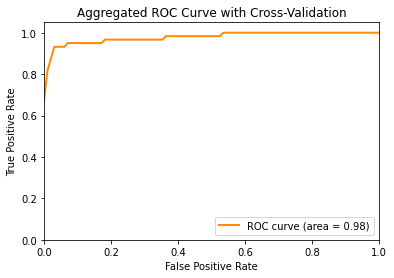

Aggregated Metrics:
  TP=9, FP=1, TN=79, FN=1
  Sens=0.8732, Spec=0.9926, Acc=0.9777, MCC=0.8890, AUC=0.9780, F1=0.8966


In [10]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
import csv

# Assuming VALIDATION_MODE, K_Fold, class_names, etc. are defined
if VALIDATION_MODE == "cross":
    x_data = np.concatenate((x_train, x_test), axis=0)
    y_data = np.concatenate((y_train, y_test), axis=0)

    metrics_summary = {'TP': [], 'FP': [], 'TN': [], 'FN': [], 'Sens': [], 'Spec': [], 'Acc': [], 'MCC': [], 'AUC': [], 'F1': []}
    roc_values = {'fpr': [], 'tpr': [], 'auc': []}

    kfold = KFold(n_splits=K_Fold, shuffle=True, random_state=2)

    for fold, (train_index, test_index) in enumerate(kfold.split(x_data)):
        X_train, X_test = x_data[train_index], x_data[test_index]
        Y_train, Y_test = y_data[train_index], y_data[test_index]

        # Replace with your model building and training code
        model = DeepScan(num_filters=NUM_FILTER, num_hidden=NUM_HIDDEN, window_sizes=WINDOW_SIZES)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.build(input_shape=X_train.shape)

        model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

        Y_pred = model.predict(X_test)

        # Calculate ROC and AUC directly from predicted probabilities
        fpr, tpr, _ = roc_curve(Y_test[:, 1], Y_pred[:, 1])  # Assuming your positive class is labeled as 1
        roc_auc = auc(fpr, tpr)

        # Save ROC values for each fold
        roc_values['fpr'].append(fpr.tolist())
        roc_values['tpr'].append(tpr.tolist())
        roc_values['auc'].append(roc_auc)

        metrics_summary['AUC'].append(roc_auc)

        cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
        TP = cm[1, 1]
        FP = cm[0, 1]
        FN = cm[1, 0]
        TN = cm[0, 0]

        metrics_summary['TP'].append(TP)
        metrics_summary['FP'].append(FP)
        metrics_summary['TN'].append(TN)
        metrics_summary['FN'].append(FN)
        metrics_summary['Sens'].append(TP / (TP + FN) if (TP + FN) else 0)
        metrics_summary['Spec'].append(TN / (TN + FP) if (TN + FP) else 0)
        metrics_summary['Acc'].append((TP + TN) / cm.sum())
        metrics_summary['MCC'].append(matthews_corrcoef(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)) if (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) else 0)
        metrics_summary['F1'].append(2 * TP / (2*TP + FP + FN) if (2*TP + FP + FN) else 0)

    # Calculate mean ROC values
    mean_fpr = np.linspace(0, 1, 100)
    tpr_interp_list = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(roc_values['fpr'], roc_values['tpr'])]
    mean_tpr = np.mean(tpr_interp_list, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    # Save aggregated ROC values to a CSV file using numpy.savetxt
    np.savetxt('roc_Prottrans.csv', np.column_stack((mean_fpr, mean_tpr, [mean_auc]*len(mean_fpr))), delimiter=',', header='Mean_FPR,Mean_TPR,Mean_AUC', comments='')

    # Load aggregated ROC values from the CSV file
    roc_data = np.loadtxt('roc_Prottrans.csv', delimiter=',', skiprows=1)

    # Extract data
    mean_fpr = roc_data[:, 0]
    mean_tpr = roc_data[:, 1]
    mean_auc = roc_data[0, 2]


    # Plot and save macro-average ROC curve
    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {mean_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Aggregated ROC Curve with Cross-Validation')
    plt.legend(loc="lower right")
    plt.savefig('aggregated_roc_curve.png', dpi=300)
    plt.show()

    # Print aggregated metrics
    print("Aggregated Metrics:")
    print(f"  TP={np.mean(metrics_summary['TP']):.0f}, FP={np.mean(metrics_summary['FP']):.0f}, TN={np.mean(metrics_summary['TN']):.0f}, FN={np.mean(metrics_summary['FN']):.0f}")
    print(f"  Sens={np.mean(metrics_summary['Sens']):.4f}, Spec={np.mean(metrics_summary['Spec']):.4f}, Acc={np.mean(metrics_summary['Acc']):.4f}, MCC={np.mean(metrics_summary['MCC']):.4f}, AUC={np.mean(metrics_summary['AUC']):.4f}, F1={np.mean(metrics_summary['F1']):.4f}")

## Independent Test and SLC analysis

Model: "deep_scan_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1, 1197, 128)      524416    
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1193, 128)      1048704   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 128)        0         
 2D)                                                             
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 128)        0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 128)               0         
                                                                 
 flatten_5 (Flatten)         (None, 128)               

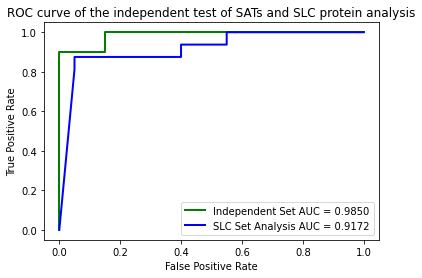

In [9]:
import matplotlib.pyplot as plt
if VALIDATION_MODE == "independent":
    model = DeepScan(
        num_filters=NUM_FILTER,
        num_hidden=NUM_HIDDEN,
        window_sizes=WINDOW_SIZES
    )
    tf.random.set_seed(42)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.build(input_shape=x_train.shape)
    model.summary()

    model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        shuffle=True,
    )

    # Assuming y_test and y_independent are one-hot encoded
    fpr_test, tpr_test, _ = roc_curve(y_test[:, 1], model.predict(x_test)[:, 1])
    fpr_independent, tpr_independent, _ = roc_curve(y_independent[:, 1], model.predict(x_independent)[:, 1])

    print("Testing on Independent Set:")
    AUC_test = model_test(model, x_test, y_test)

    print("Testing on SLC Set Analysis:")
    AUC_independent = model_test(model, x_independent, y_independent)

    # Plot ROC curves
    plt.figure()
    plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Independent Set AUC = {AUC_test:.4f}')
    plt.plot(fpr_independent, tpr_independent, color='blue', lw=2, label=f'SLC Set Analysis AUC = {AUC_independent:.4f}')
    #plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('ROC curve of the independent test of SATs and SLC protein analysis')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    # Save the figure with high resolution (e.g., dpi=300)
    plt.savefig('roc_curve_independent.png', dpi=300)
    plt.show()

## ROC Curve for Comparasions

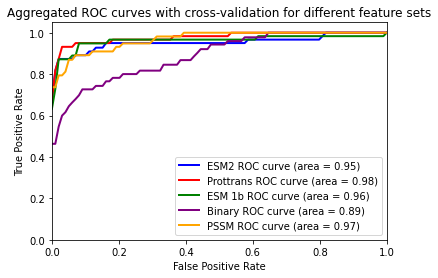

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load aggregated ROC values from the CSV files
roc_esm2_data = pd.read_csv('roc_esm2.csv')
roc_prottrans_data = pd.read_csv('roc_Prottrans.csv')
roc_esm_1b_data = pd.read_csv('roc_esm_1b.csv')
roc_binary_data = pd.read_csv('roc_binary.csv')
roc_pssm_data = pd.read_csv('roc_pssm.csv')

# Extract mean FPR, mean TPR, and mean AUC from the loaded data
mean_fpr_esm2 = roc_esm2_data['Mean_FPR'].values
mean_tpr_esm2 = roc_esm2_data['Mean_TPR'].values
mean_auc_esm2 = roc_esm2_data['Mean_AUC'].values[0]

mean_fpr_prottrans = roc_prottrans_data['Mean_FPR'].values
mean_tpr_prottrans = roc_prottrans_data['Mean_TPR'].values
mean_auc_prottrans = roc_prottrans_data['Mean_AUC'].values[0]

mean_fpr_esm_1b = roc_esm_1b_data['Mean_FPR'].values
mean_tpr_esm_1b = roc_esm_1b_data['Mean_TPR'].values
mean_auc_esm_1b = roc_esm_1b_data['Mean_AUC'].values[0]

mean_fpr_binary = roc_binary_data['Mean_FPR'].values
mean_tpr_binary = roc_binary_data['Mean_TPR'].values
mean_auc_binary = roc_binary_data['Mean_AUC'].values[0]

mean_fpr_pssm = roc_pssm_data['Mean_FPR'].values
mean_tpr_pssm = roc_pssm_data['Mean_TPR'].values
mean_auc_pssm = roc_pssm_data['Mean_AUC'].values[0]

# Plot the aggregated ROC curves
plt.figure()
plt.plot(mean_fpr_esm2, mean_tpr_esm2, color='blue', lw=2, label=f'ESM2 ROC curve (area = {mean_auc_esm2:.2f})')
plt.plot(mean_fpr_prottrans, mean_tpr_prottrans, color='red', lw=2, label=f'Prottrans ROC curve (area = {mean_auc_prottrans:.2f})')
plt.plot(mean_fpr_esm_1b, mean_tpr_esm_1b, color='green', lw=2, label=f'ESM 1b ROC curve (area = {mean_auc_esm_1b:.2f})')
plt.plot(mean_fpr_binary, mean_tpr_binary, color='purple', lw=2, label=f'Binary ROC curve (area = {mean_auc_binary:.2f})')
plt.plot(mean_fpr_pssm, mean_tpr_pssm, color='orange', lw=2, label=f'PSSM ROC curve (area = {mean_auc_pssm:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Aggregated ROC curves with cross-validation for different feature sets')
plt.legend(loc="lower right")
#Save the figure with high resolution (e.g., dpi=300)
plt.savefig('roc_curve_diffrent_featuresSet.png', dpi=300)
plt.show()
